In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

!pip -q install medmnist

import medmnist
from medmnist import INFO, Evaluator
!python -m medmnist available


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 46.4 MB/s eta 0:00:00
MedMNIST v3.0.1 @ https://github.com/MedMNIST/MedMNIST/
All available datasets:
	pathmnist       | PathMNIST       | Size: 28 (default), 64, 128, 224.
	chestmnist      | ChestMNIST      | Size: 28 (default), 64, 128, 224.
	dermamnist      | DermaMNIST      | Size: 28 (default), 64, 128, 224.
	octmnist        | OCTMNIST        | Size: 28 (default), 64, 128, 224.
	pneumoniamnist  | PneumoniaMNIST  | Size: 28 (default), 64, 128, 224.
	retinamnist     | RetinaMNIST     | Size: 28 (default), 64, 128, 224.
	breastmnist     | BreastMNIST     | Size: 28 (default), 64, 128, 224.
	bloodmnist      | BloodMNIST      | Size: 28 (default), 64, 128, 224.
	tissuemnist     | TissueMNIST     | Size: 28 (default), 64, 128, 224.
	organamnist     | OrganAMNIST     | Size: 28 (default), 64, 128, 224.
	organcm

In [3]:
data_path = '/content/'
train_dataset = medmnist.PneumoniaMNIST(split ='train', download = True, size=128, root = data_path)
train_dataset = medmnist.PneumoniaMNIST(split = 'test', download = True, size=128, root = data_path)

100%|██████████| 75506212/75506212 [00:03<00:00, 20265299.41it/s]


Using downloaded and verified file: /content/pneumoniamnist_128.npz


In [6]:
data = np.load('/content/pneumoniamnist_128.npz')
data.files

['train_images',
 'train_labels',
 'val_images',
 'val_labels',
 'test_images',
 'test_labels']

In [7]:
data['train_images'].shape

(4708, 128, 128)

In [8]:
data['val_images'].shape

(524, 128, 128)

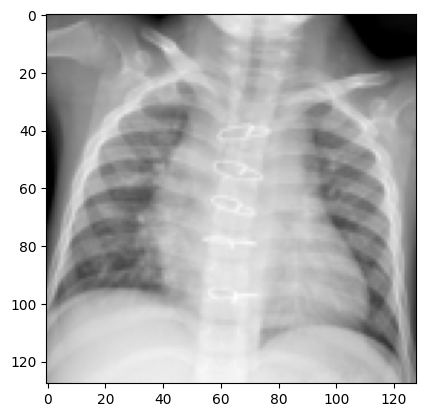

In [9]:
plt.imshow(data['train_images'][0], cmap = 'gray')

Data Preparation Stage

In [11]:
(train_images, train_labels) = (data['train_images'], data['train_labels'])
(val_images, val_labels) = (data['val_images'], data['val_labels'])
(test_images, test_labels) = (data['test_images'], data['test_labels'])

In [12]:
train_images = train_images.astype('float32') / 255.0
val_images = val_images.astype('float32') /255.0
test_images = test_images.astype('float32') /255.0

In [13]:
train_images = tf.reshape(train_images, (-1, 128, 128, 1))
val_images = tf.reshape(val_images, (-1, 128, 128, 1))
test_images = tf.reshape(test_images, (-1, 128, 128, 1))

In [14]:
train_labels = to_categorical(train_labels)
val_labels = to_categorical(val_labels)
test_labels = to_categorical(test_labels)

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

In [17]:
train_dataset = train_dataset.shuffle(buffer_size = 1024).batch(batch_size =64)
val_dataset = val_dataset.batch(batch_size = 64)
test_dataset = test_dataset.batch(batch_size = 64)

train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, None, 128, 128, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 2), dtype=tf.float32, name=None))>

**# Model Implementation**
Convolutional layer
Pooling layer
Dense(Linear) layer
Drop out layers

In [21]:
model = tf.keras.models.Sequential([

   tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', input_shape =(128, 128,1)),
   tf.keras.layers.MaxPooling2D(2,2),

   tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
   tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'),
     tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'),
     tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0,5),

    tf.keras.layers.Dense (512, activation ='relu'),
    tf.keras.layers.Dense (2, activation ='softmax'),

                                    ])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 64)      640       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 63, 63, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 128)      

In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer='rmsprop', metrics=['acuracy'])
history = model.fit(train_dataset, epochs=25, steps_per_epoch=10, validation_data = val_dataset, verbose = 1, validation_steps=3)
model.save('Pneumonia-Model.keras')